# LISA FD for PhenomD waveforms : check interpolation errors

Sylvain Marsat | 2018-07-01

## Loading

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt

In [5]:
import sys
sys.path.append('../IMRPhenomD/')
sys.path.append('../../../Packages/common/')

In [6]:
from pyFDresponse import *

## Definitions

In [7]:
# Logarithmic sampling
def logspacing(start, stop, nb):
    ratio = (stop/start)**(1./(nb-1))
    return start * np.power(ratio, np.arange(nb))

In [9]:
# Color palette stolen from seaborn package (deep, with reshuffled ordering)
# SEABORN_PALETTES = dict(
#     deep=["#4C72B0", "#55A868", "#C44E52",
#           "#8172B2", "#CCB974", "#64B5CD"],
#     muted=["#4878CF", "#6ACC65", "#D65F5F",
#            "#B47CC7", "#C4AD66", "#77BEDB"],
#     pastel=["#92C6FF", "#97F0AA", "#FF9F9A",
#             "#D0BBFF", "#FFFEA3", "#B0E0E6"],
#     bright=["#003FFF", "#03ED3A", "#E8000B",
#             "#8A2BE2", "#FFC400", "#00D7FF"],
#     dark=["#001C7F", "#017517", "#8C0900",
#           "#7600A1", "#B8860B", "#006374"],
#     colorblind=["#0072B2", "#009E73", "#D55E00",
#                 "#CC79A7", "#F0E442", "#56B4E9"]
#)
palette = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD"]

In [8]:
def plot_wf_ampphase(wf):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    f, amp, phase = wf
    ax1.plot(f, amp, color=palette[0])
    ax1.set_xlim(min(f), max(f))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid()
    ax2.plot(f, phase, color=palette[0])
    ax2.set_xlim(min(f), max(f))
    ax2.set_xscale('log')
    ax2.grid()
    plt.show()

In [10]:
def plot_wf_tdi_all(wf, scalebyf2=False):
    fig, ax = plt.subplots(2, 3, figsize=(16,8))
    f, amp, phase, f_response, phaseRdelay, transferL1, transferL2, transferL3, TDItag = wf['freq'], wf['amp'], wf['phase'], wf['freq_response'], wf['phaseRdelay'], wf['transferL1'], wf['transferL2'], wf['transferL3'], wf['TDItag']
    # Common settings
    for i in range(2):
        for j in range(3):
            ax[i][j].set_xlim(min(f), max(f))
            ax[i][j].set_xscale('log')
            ax[i][j].set_xlabel(r'f (Hz)')
            ax[i][j].grid()
    # Amp
    ax[0][0].plot(f, amp, color=palette[0])
    ax[0][0].set_yscale('log')
    ax[0][0].set_ylabel(r'$A_{22}$')
    ax[0][0].set_title(r'Amplitude')
    # Phase
    ax[0][1].plot(f, phase, color=palette[0])
    ax[0][1].set_xscale('log')
    ax[0][1].set_ylabel(r'$\Phi_{22}$')
    ax[0][1].set_title(r'Phase')
    # Orbital delay phase
    ax[0][2].plot(f_response, phaseRdelay, color=palette[0])
    ax[0][2].set_xscale('log')
    ax[0][2].axhline(0, color='k')
    ax[0][2].set_ylabel(r'$\Phi_{d_0}$')
    ax[0][2].set_title(r'Orbital delay phase')
    # TDI and transfer
    transL = {}
    if scalebyf2:
        fstar = C_SI/L_SI
        transL[1], transL[2], transL[3] = transferL1*(fstar/f_response)**2, transferL2*(fstar/f_response)**2, transferL3*(fstar/f_response)**2
    else:
        transL[1], transL[2], transL[3] = transferL1, transferL2, transferL3
    # Labels
    tdilabel = {}
    if TDItag=='TDIXYZ':
        tdilabel[1] = 'X'
        tdilabel[2] = 'Y'
        tdilabel[3] = 'Z'
    elif TDItag=='TDIAET':
        tdilabel[1] = 'A'
        tdilabel[2] = 'E'
        tdilabel[3] = 'T'
    else:
        raise ValueError("Error in plot_wf_tdi: TDItag not recognized.")
    ylabeltrans = {}; titletrans = {}; ylabeltdi = {}; titletdi = {};
    for i in range(1,4):
        if scalebyf2:
            ylabeltrans[i] = r'$(f_{*}/f)^2\mathcal{T}^L_'+tdilabel[i]+'$'
        else:
            ylabeltrans[i] = r'$\mathcal{T}^L_'+tdilabel[i]+'$'
        titletrans[i] = r'Transfer '+tdilabel[i]+' Re/Im'
        ylabeltdi[i] = r'$\mathrm{TDI}_'+tdilabel[i]+'$'
        titletdi[i] = r'TDI '+tdilabel[i]+' Re/Im'
    # Plot transfer
    for i in range(1,4):
        ax[1][i-1].plot(f_response, np.real(transL[i]), color=palette[0])
        ax[1][i-1].plot(f_response, np.imag(transL[i]), color=palette[1])
        ax[1][i-1].axhline(0, color='k')
        ax[1][i-1].set_ylabel(ylabeltrans[i])
        ax[1][i-1].set_title(titletrans[i])
    plt.tight_layout()
    plt.show()

In [11]:
def plot_wf_tdi_interp_residual(wf, wf_HiS, scalebyf2=False):
    fig, ax = plt.subplots(2, 3, figsize=(16,8))
    f, amp, phase, f_response, phaseRdelay, transferL1, transferL2, transferL3, TDItag = wf['freq'], wf['amp'], wf['phase'], wf['freq_response'], wf['phaseRdelay'], wf['transferL1'], wf['transferL2'], wf['transferL3'], wf['TDItag']
    f_HiS, amp_HiS, phase_HiS, f_response_HiS, phaseRdelay_HiS, transferL1_HiS, transferL2_HiS, transferL3_HiS, TDItag_HiS = wf_HiS['freq'], wf_HiS['amp'], wf_HiS['phase'], wf_HiS['freq_response'], wf_HiS['phaseRdelay'], wf_HiS['transferL1'], wf_HiS['transferL2'], wf_HiS['transferL3'], wf_HiS['TDItag']
    # Common settings
    for i in range(2):
        for j in range(3):
            ax[i][j].set_xlim(min(f), max(f))
            ax[i][j].set_ylim(1e-12, 1.)
            ax[i][j].set_xscale('log')
            ax[i][j].set_xlabel(r'f (Hz)')
            ax[i][j].grid()
    # Amp
    spline_amp = spline(f, amp)
    ax[0][0].plot(f_HiS, np.abs((spline_amp(freq_HiS)-amp_HiS))/amp_HiS, color=palette[0])
    ax[0][0].set_yscale('log')
    ax[0][0].set_ylabel(r'$\Delta A_{22} / A_{22}$')
    ax[0][0].set_title(r'Amplitude')
    # Phase
    spline_phase = spline(f, phase)
    ax[0][1].plot(f_HiS, np.abs(spline_phase(freq_HiS)-phase_HiS), color=palette[0])
    ax[0][1].set_xscale('log')
    ax[0][1].set_yscale('log')
    ax[0][1].set_ylabel(r'$\Delta \Phi_{22}$')
    ax[0][1].set_title(r'Phase')
    # Orbital delay phase
    spline_phaseRdelay = spline(f_response, phaseRdelay)
    ax[0][2].plot(f_response_HiS, np.abs(spline_phaseRdelay(f_response_HiS) - phaseRdelay_HiS), color=palette[0])
    ax[0][2].set_xscale('log')
    ax[0][2].set_yscale('log')
    ax[0][2].axhline(0, color='k')
    ax[0][2].set_ylabel(r'$\Delta \Phi_{d_0}$')
    ax[0][2].set_title(r'Orbital delay phase')
    # TDI and transfer
    transL = {}
    transL_HiS = {}
    if scalebyf2:
        fstar = C_SI/L_SI
        transL[1], transL[2], transL[3] = transferL1*(fstar/f_response)**2, transferL2*(fstar/f_response)**2, transferL3*(fstar/f_response)**2
        transL_HiS[1], transL_HiS[2], transL_HiS[3] = transferL1_HiS*(fstar/f_response_HiS)**2, transferL2_HiS*(fstar/f_response_HiS)**2, transferL3_HiS*(fstar/f_response_HiS)**2
    else:
        transL[1], transL[2], transL[3] = transferL1, transferL2, transferL3
        transL_HiS[1], transL_HiS[2], transL_HiS[3] = transferL1_HiS, transferL2_HiS, transferL3_HiS
    # Labels
    tdilabel = {}
    if TDItag=='TDIXYZ':
        tdilabel[1] = 'X'
        tdilabel[2] = 'Y'
        tdilabel[3] = 'Z'
    elif TDItag=='TDIAET':
        tdilabel[1] = 'A'
        tdilabel[2] = 'E'
        tdilabel[3] = 'T'
    else:
        raise ValueError("Error in plot_wf_tdi: TDItag not recognized.")
    ylabeltrans = {}; titletrans = {}; ylabeltdi = {}; titletdi = {};
    for i in range(1,4):
        if scalebyf2:
            ylabeltrans[i] = r'$(f_{*}/f)^2\Delta\mathcal{T}^L_'+tdilabel[i]+'$'
        else:
            ylabeltrans[i] = r'$\Delta\mathcal{T}^L_'+tdilabel[i]+'$'
        titletrans[i] = r'Transfer '+tdilabel[i]+' Re/Im'
        ylabeltdi[i] = r'$\mathrm{TDI}_'+tdilabel[i]+'$'
        titletdi[i] = r'TDI '+tdilabel[i]+' Re/Im'
    # Plot transfer
    for i in range(1,4):
        spline_transL_real = spline(f_response, np.real(transL[i]))
        spline_transL_imag = spline(f_response, np.imag(transL[i]))
        ax[1][i-1].plot(f_response_HiS, np.abs((spline_transL_real(f_response_HiS)+1j*spline_transL_imag(f_response_HiS)) - (transL_HiS[i])), color=palette[0])
        ax[1][i-1].set_xscale('log')
        ax[1][i-1].set_yscale('log')
        ax[1][i-1].set_ylabel(ylabeltrans[i])
        ax[1][i-1].set_title(titletrans[i])
    plt.tight_layout()
    plt.show()

In [12]:
# Restrict data to an interval according to first column
def restrict_data(data, interval):
    if not interval: # test if interval==[]
        return data
    else:
        # Make an initial guess based on global length - then adjust starting and ending indices
        x = data[:,0]
        n = len(data)
        deltax = (x[-1] - x[0]) / n
        if interval[0] < x[0]:
            ibeg = 0
        else:
            ibeg = min(int((interval[0]-x[0]) / deltax), n-1)
            while ibeg < n and x[ibeg] < interval[0]:
                ibeg += 1
            while ibeg > 0 and x[ibeg-1] > interval[0]:
                ibeg -= 1
        if interval[-1] > x[-1]:
            iend = n-1
        else:
            iend = n-1 - min(int((x[-1] - interval[-1]) / deltax), n-1)
            while iend > 0 and x[iend] > interval[-1]:
                iend -= 1
            while iend < n-1 and x[iend+1] < interval[-1]:
                iend += 1
        return data[ibeg:iend+1]

In [13]:
# Color palette stolen from seaborn package (deep, with reshuffled ordering)
# SEABORN_PALETTES = dict(
#     deep=["#4C72B0", "#55A868", "#C44E52",
#           "#8172B2", "#CCB974", "#64B5CD"],
#     muted=["#4878CF", "#6ACC65", "#D65F5F",
#            "#B47CC7", "#C4AD66", "#77BEDB"],
#     pastel=["#92C6FF", "#97F0AA", "#FF9F9A",
#             "#D0BBFF", "#FFFEA3", "#B0E0E6"],
#     bright=["#003FFF", "#03ED3A", "#E8000B",
#             "#8A2BE2", "#FFC400", "#00D7FF"],
#     dark=["#001C7F", "#017517", "#8C0900",
#           "#7600A1", "#B8860B", "#006374"],
#     colorblind=["#0072B2", "#009E73", "#D55E00",
#                 "#CC79A7", "#F0E442", "#56B4E9"]
#)
palette = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD"]
def lplot(ax, *args, **kwargs):
    rangex = kwargs.get('rangex', [])
    rangey = kwargs.get('rangey', [])
    ds = kwargs.get('downsample', 1)
    size = kwargs.get('figsize', (8, 4))
    grid = kwargs.get('grid', True)
    colormap = kwargs.get('colormap', None)
    colormapbounds = kwargs.get('colormapbounds', [0.,1.])
    colors = kwargs.get('colors', None)
    linestyles = kwargs.get('linestyles', None)
    log_xscale = kwargs.get('log_xscale', False)
    log_yscale = kwargs.get('log_yscale', False)
    n = len(args)
    if colors is None: # colors option supersedes colormap
        if colormap is not None:
            colorm = cm.get_cmap(colormap)
            colors = [colorm(x) for x in np.linspace(colormapbounds[0], colormapbounds[1], n)]
        else:
            #defaultcolorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']
            defaultcolorlist = palette
            colors = fold_list(defaultcolorlist, n)
    if linestyles is None:
        linestyles = ['-' for i in range(n)]
    f = plt.figure(0, figsize=size)
    minxvals = np.zeros(n)
    maxxvals = np.zeros(n)
    minyvals = np.zeros(n)
    maxyvals = np.zeros(n)
    avyvals = np.zeros(n)
    for i, x in enumerate(args):
        if type(x[1]) is np.ndarray:
            data = restrict_data(np.array([x[0][::ds], x[1][::ds]]).T, rangex)
            col1, col2 = [0, 1]
        else:
            data = restrict_data(x[0][::ds], rangex)
            col1, col2 = x[1]
        if not log_xscale:
            minxvals[i] = data[0, col1]
        else: # Restrict to the first non-zero value of y - convenient for log-x plots (also always exclude x=0)
            datax = data[:, col1]
            datay = data[:, col2]
            if datax[0]==0.:
                datax = datax[1:]
                datay = datay[1:]
            minxvals[i] = datax[(datay > 0)][0]
        maxxvals[i] = data[-1, col1]
        minyvals[i] = min(data[:, col2])
        maxyvals[i] = max(data[:, col2])
        avyvals[i] = np.average(data[:, col2])
        ax.plot(data[:,col1], data[:,col2], color=colors[i], linestyle=linestyles[i])
    if rangex:
        ax.set_xlim(rangex[0], rangex[1])
    else:
        ax.set_xlim(min(minxvals), max(maxxvals))
    if rangey:
        ax.set_ylim(rangey[0], rangey[1])
    else:
        if log_yscale:
            minyvalplot = max(min(minyvals), 1e-8*np.average(avyvals))
            ax.set_ylim(1./1.5*minyvalplot, 1.5*max(maxyvals))
        else:
            margin = 0.1 * (max(maxyvals) - np.average(avyvals))
            ax.set_ylim(min(minyvals) - margin, max(maxyvals) + margin)
    if log_xscale:
        ax.set_xscale('log')
    if log_yscale:
        ax.set_yscale('log')
    if grid:
        ax.grid()
        
def llogplot(ax, *arg, **kwargs):
    args = (ax,) + arg
    return lplot(*args, log_yscale=True, **kwargs)
def lloglinearplot(ax, *arg, **kwargs):
    args = (ax,) + arg
    return lplot(*args, log_xscale=True, **kwargs)
def lloglogplot(ax, *arg, **kwargs):
    args = (ax,) + arg
    return lplot(*args, log_xscale=True, log_yscale=True, **kwargs)

## LISA FD response: examples

### Common parameters

In [14]:
# Some generic values for the orientation parameters
# 36.6 Gpc corresponds to z=4
[phi0, fRef, chi1, chi2, dist, inc, lambd, beta, psi] = [1.2, 0., 0.9, -0.8, 36.6e3, pi/3, 1.7, 1.05, 2.3]
# So far, the only choice implemented: MLDC trajectories and TDI XYZ
[t0, trajdict, TDItag] = [0., trajdict_MLDC, "TDIXYZ"]
# 4 years of observations, frequency band from 1e-5Hz to 1Hz
[minf, maxf, tobs] = [1e-5, 1., 4.]

### [m1,m2] = [4e8, 2e8] Msol

In [15]:
[m1, m2] = [4e8, 2e8]

In [16]:
wf = GenerateResamplePhenomD(phi0, fRef, m1, m2, chi1, chi2, dist, inc, tobs, minf, maxf)

In [17]:
freq_response = ResponseFrequencyGrid(wf)

In [18]:
wf_tdi = LISAFDresponseTDI(freq_response, wf, inc, lambd, beta, psi, t0=t0, trajdict=trajdict, TDItag=TDItag)

In [19]:
print("Nb of f samples for waveform: %d"%len(wf[0]))
print("Nb of f samples for response: %d"%len(freq_response))

Nb of f samples for waveform: 77
Nb of f samples for response: 101


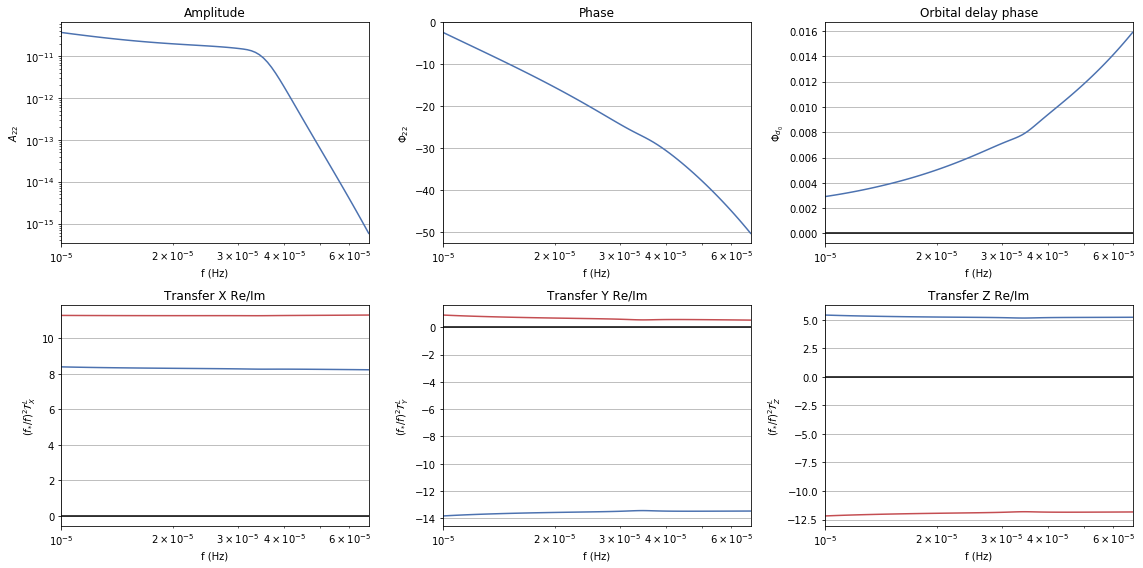

In [20]:
plot_wf_tdi_all(wf_tdi, scalebyf2=True)

In [21]:
# Generate the waveform and response on a dense sampling
m1_SI = m1*MSUN_SI
m2_SI = m2*MSUN_SI
dist_SI = dist*1e6*PC_SI
npt_HiS = 10000
freq_HiS = logspacing(wf[0][0], wf[0][-1], npt_HiS)
wf_PhD_class = pyIMRPhenomD.IMRPhenomDh22AmpPhase(freq_HiS, phi0, fRef, m1_SI, m2_SI, chi1, chi2, dist_SI)
wf_HiS = wf_PhD_class.GetWaveform()
freq_response_HiS = logspacing(freq_response[0], freq_response[-1], 10000)
wf_tdi_HiS = LISAFDresponseTDI(freq_response_HiS, wf_HiS, inc, lambd, beta, psi, t0=t0, trajdict=trajdict, TDItag=TDItag)

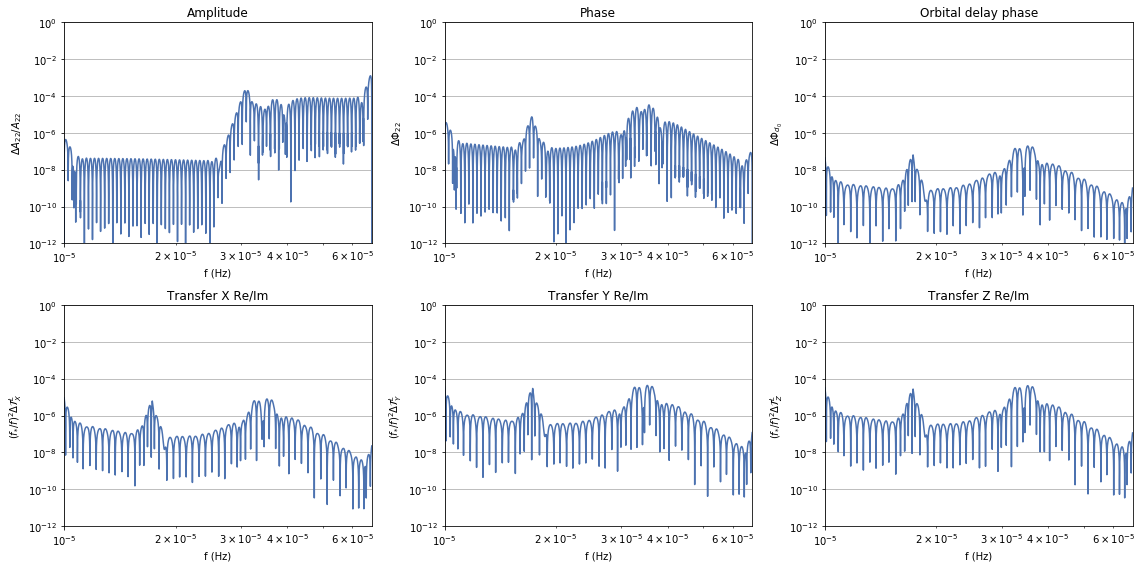

In [22]:
plot_wf_tdi_interp_residual(wf_tdi, wf_tdi_HiS, scalebyf2=True)

### [m1,m2] = [2e6, 1e6] Msol

In [150]:
[m1, m2] = [2e6, 1e6]

In [151]:
wf = GenerateResamplePhenomD(phi0, fRef, m1, m2, chi1, chi2, dist, inc, tobs, minf, maxf)

In [152]:
freq_response = ResponseFrequencyGrid(wf)

In [153]:
wf_tdi = LISAFDresponseTDI(freq_response, wf, inc, lambd, beta, psi, t0=t0, trajdict=trajdict, TDItag=TDItag)

In [154]:
print("Nb of f samples for waveform: %d"%len(wf[0]))
print("Nb of f samples for response: %d"%len(freq_response))

Nb of f samples for waveform: 274
Nb of f samples for response: 177


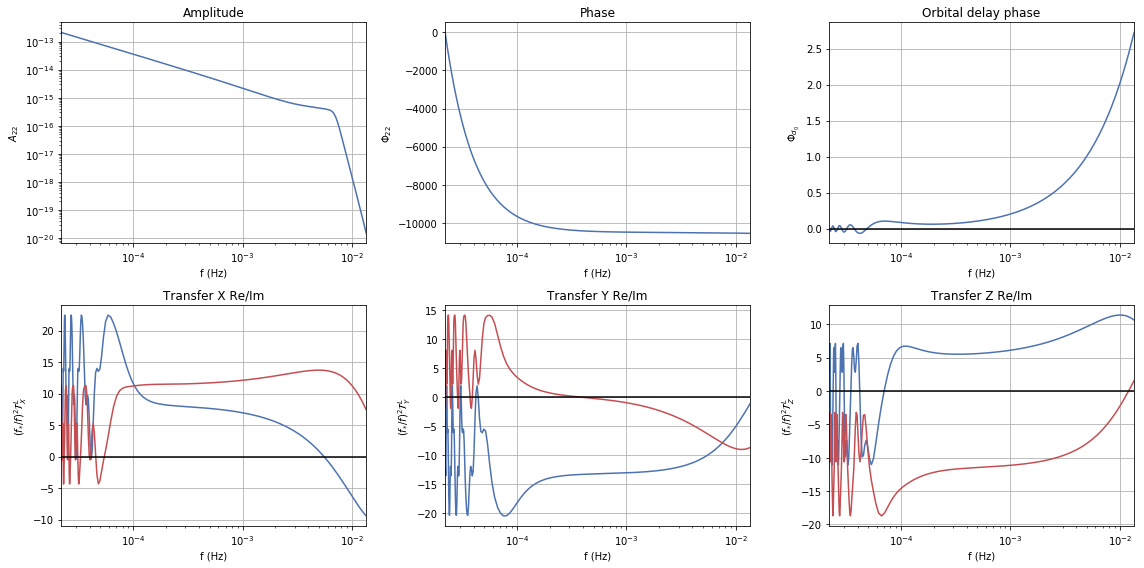

In [155]:
plot_wf_tdi_all(wf_tdi, scalebyf2=True)

In [156]:
# Generate the waveform and response on a dense sampling
m1_SI = m1*MSUN_SI
m2_SI = m2*MSUN_SI
dist_SI = dist*1e6*PC_SI
npt_HiS = 10000
freq_HiS = logspacing(wf[0][0], wf[0][-1], npt_HiS)
wf_PhD_class = pyIMRPhenomD.IMRPhenomDh22AmpPhase(freq_HiS, phi0, fRef, m1_SI, m2_SI, chi1, chi2, dist_SI)
wf_HiS = wf_PhD_class.GetWaveform()
freq_response_HiS = logspacing(freq_response[0], freq_response[-1], 10000)
wf_tdi_HiS = LISAFDresponseTDI(freq_response_HiS, wf_HiS, inc, lambd, beta, psi, t0=t0, trajdict=trajdict, TDItag=TDItag)

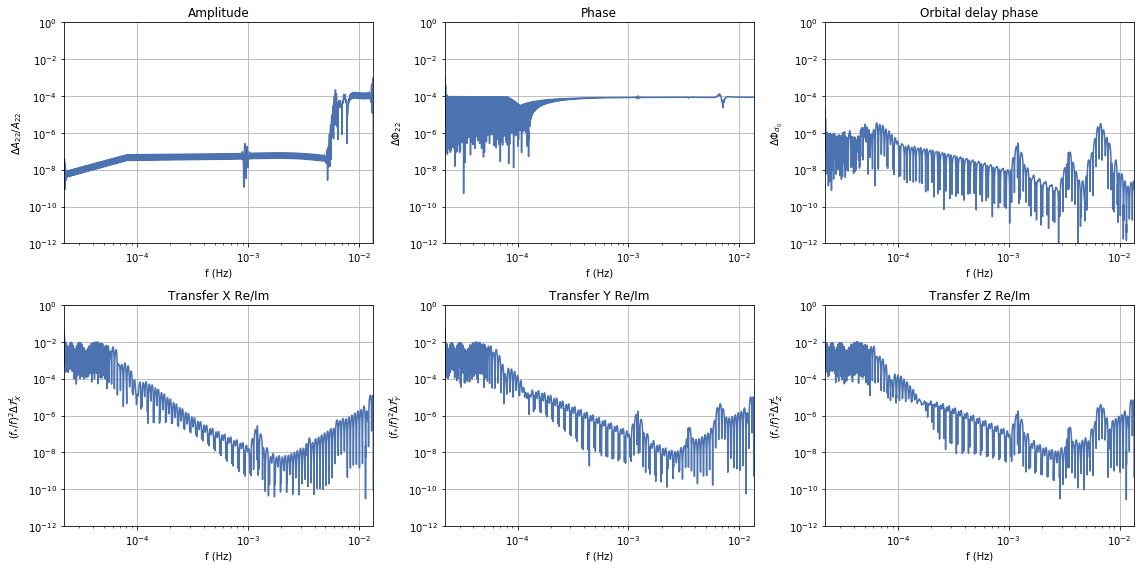

In [141]:
plot_wf_tdi_interp_residual(wf_tdi, wf_tdi_HiS, scalebyf2=True)

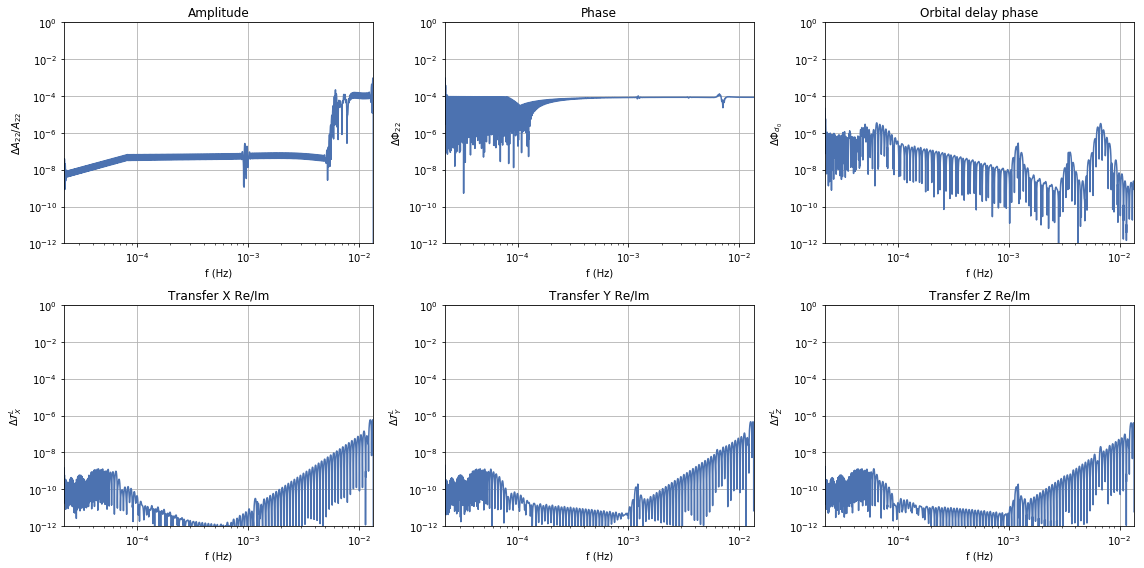

In [157]:
plot_wf_tdi_interp_residual(wf_tdi, wf_tdi_HiS, scalebyf2=False)

### [m1,m2] = [1e4, 5e3] Msol

In [142]:
[m1, m2] = [1e4, 5e3]

In [143]:
wf = GenerateResamplePhenomD(phi0, fRef, m1, m2, chi1, chi2, dist, inc, tobs, minf, maxf)

In [144]:
freq_response = ResponseFrequencyGrid(wf)

In [145]:
wf_tdi = LISAFDresponseTDI(freq_response, wf, inc, lambd, beta, psi, t0=t0, trajdict=trajdict, TDItag=TDItag)

In [146]:
print("Nb of f samples for waveform: %d"%len(wf[0]))
print("Nb of f samples for response: %d"%len(freq_response))

Nb of f samples for waveform: 446
Nb of f samples for response: 616


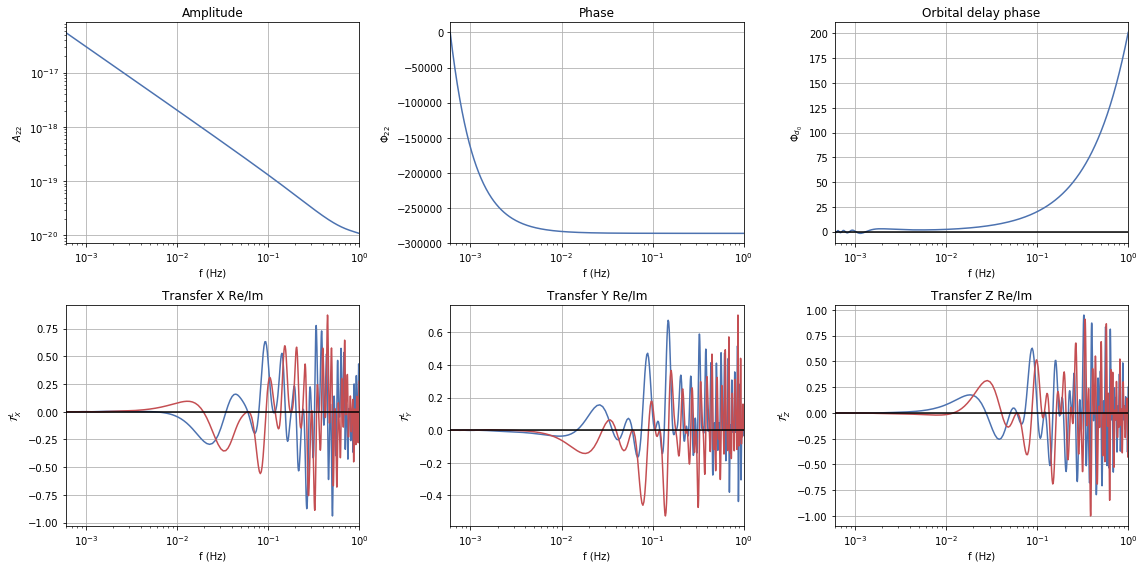

In [147]:
plot_wf_tdi_all(wf_tdi, scalebyf2=False)

In [148]:
# Generate the waveform and response on a dense sampling
m1_SI = m1*MSUN_SI
m2_SI = m2*MSUN_SI
dist_SI = dist*1e6*PC_SI
npt_HiS = 10000
freq_HiS = logspacing(wf[0][0], wf[0][-1], npt_HiS)
wf_PhD_class = pyIMRPhenomD.IMRPhenomDh22AmpPhase(freq_HiS, phi0, fRef, m1_SI, m2_SI, chi1, chi2, dist_SI)
wf_HiS = wf_PhD_class.GetWaveform()
freq_response_HiS = logspacing(freq_response[0], freq_response[-1], 10000)
wf_tdi_HiS = LISAFDresponseTDI(freq_response_HiS, wf_HiS, inc, lambd, beta, psi, t0=t0, trajdict=trajdict, TDItag=TDItag)

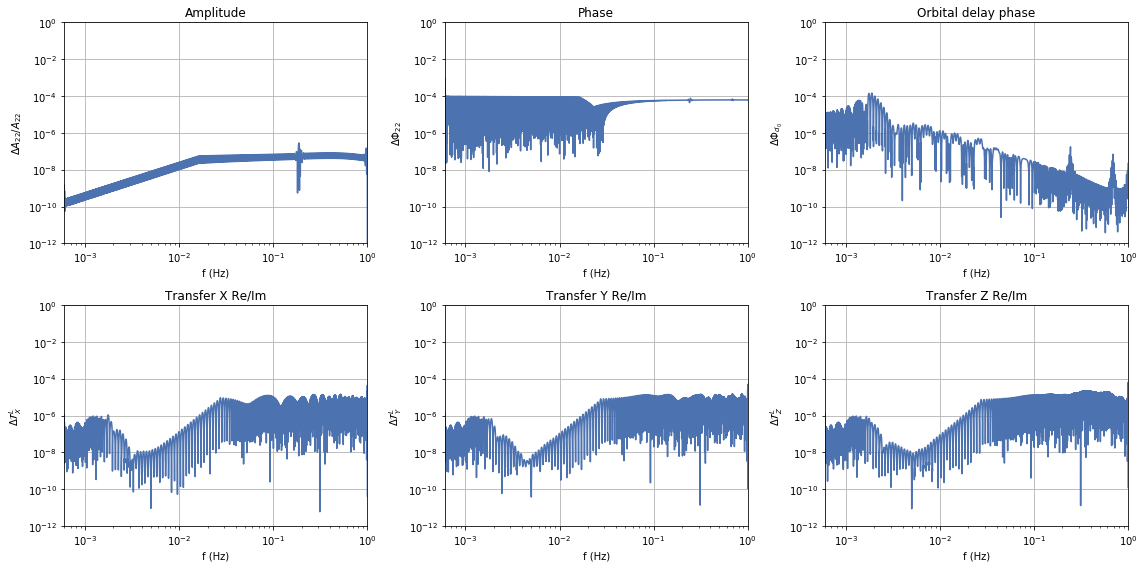

In [149]:
plot_wf_tdi_interp_residual(wf_tdi, wf_tdi_HiS, scalebyf2=False)

### [m1,m2] = [40, 20] Msol

In [158]:
[m1, m2] = [40, 20]

In [159]:
wf = GenerateResamplePhenomD(phi0, fRef, m1, m2, chi1, chi2, dist, inc, tobs, minf, maxf)

In [160]:
freq_response = ResponseFrequencyGrid(wf)

In [161]:
wf_tdi = LISAFDresponseTDI(freq_response, wf, inc, lambd, beta, psi, t0=t0, trajdict=trajdict, TDItag=TDItag)

In [162]:
print("Nb of f samples for waveform: %d"%len(wf[0]))
print("Nb of f samples for response: %d"%len(freq_response))

Nb of f samples for waveform: 718
Nb of f samples for response: 566


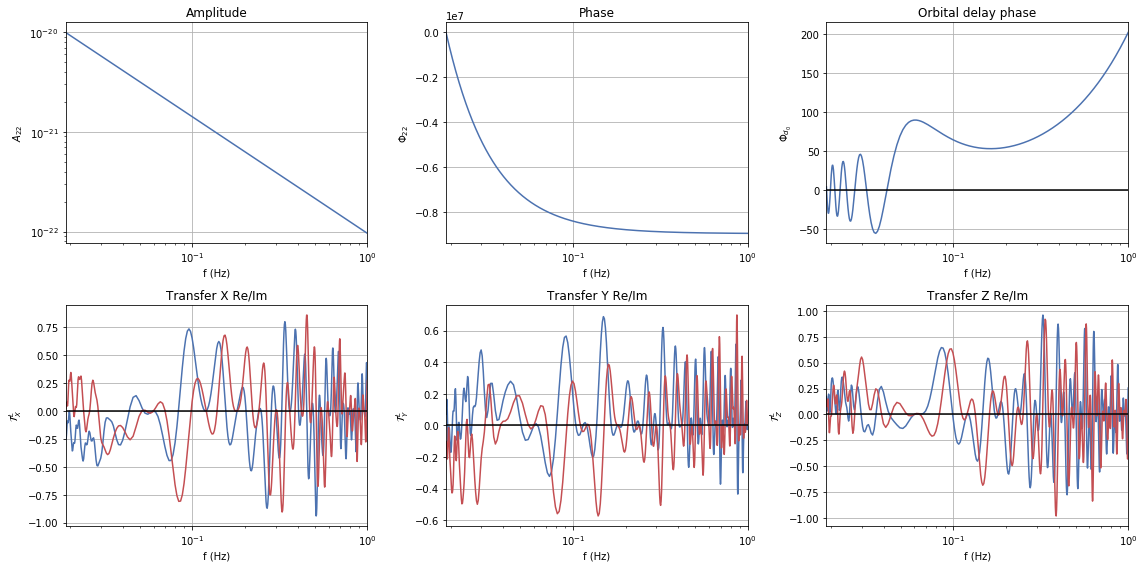

In [163]:
plot_wf_tdi_all(wf_tdi, scalebyf2=False)

In [164]:
# Generate the waveform and response on a dense sampling
m1_SI = m1*MSUN_SI
m2_SI = m2*MSUN_SI
dist_SI = dist*1e6*PC_SI
npt_HiS = 10000
freq_HiS = logspacing(wf[0][0], wf[0][-1], npt_HiS)
wf_PhD_class = pyIMRPhenomD.IMRPhenomDh22AmpPhase(freq_HiS, phi0, fRef, m1_SI, m2_SI, chi1, chi2, dist_SI)
wf_HiS = wf_PhD_class.GetWaveform()
freq_response_HiS = logspacing(freq_response[0], freq_response[-1], 10000)
wf_tdi_HiS = LISAFDresponseTDI(freq_response_HiS, wf_HiS, inc, lambd, beta, psi, t0=t0, trajdict=trajdict, TDItag=TDItag)

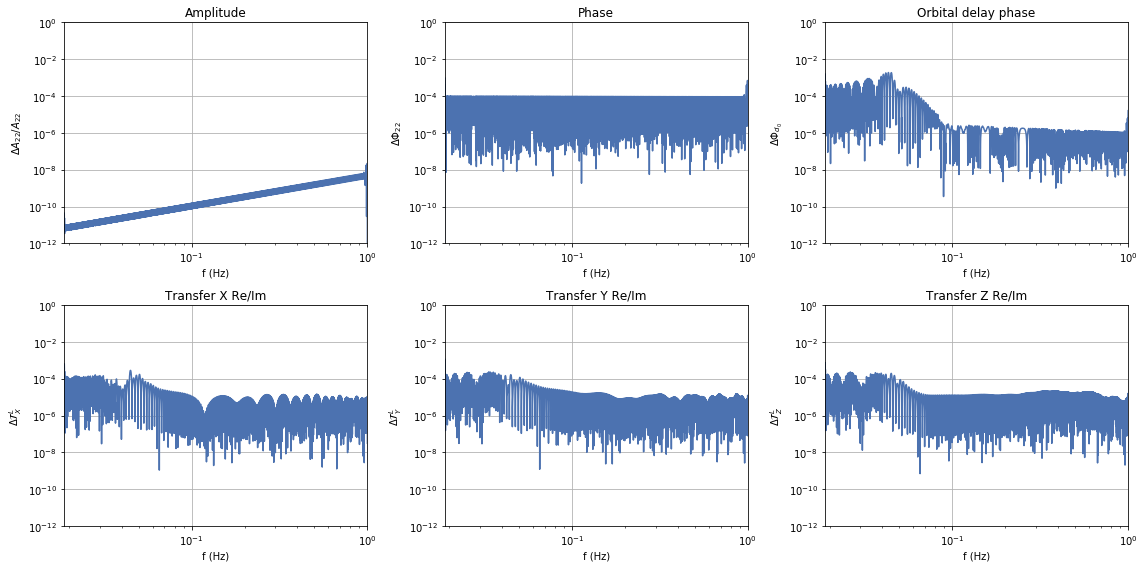

In [165]:
plot_wf_tdi_interp_residual(wf_tdi, wf_tdi_HiS, scalebyf2=False)